# Non linear model ($L_e(d), Bl(d), K_m(d)$)

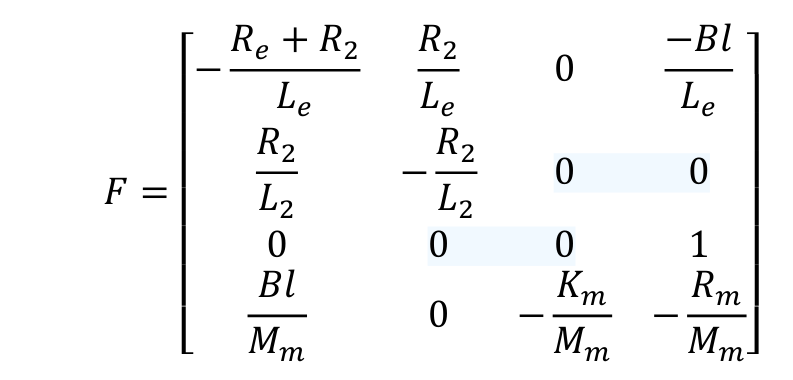

- valg af fs ud fra F?
- 

## Euler

In [5]:
%load_ext autoreload
%autoreload 2
import util
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np 
import engutil

F_linear_static = np.array([
    [-(R_e + R_20)/L_e0,  R_20/L_e0,    0.0,         -Bl/L_e0],
    [R_20/L_20,          -R_20/L_20,    0.0,          0.0 ],
    [0.0,                   0.0,            0.0,          1.0],
    [Bl/M_m,                0.0,           -K_m/M_m,   -R_m/M_m ]
])

duration = 5

minimum_fs = util.calculate_min_fs(F_linear_static)
print(f"Minimum fs: {minimum_fs:.2f}")
fs = int(5*minimum_fs)
print(f"fs: {fs}")
# 1. create input signal
u = util.generate_pink_noise(fs*duration, fs, fmin=1)


params, polys = load_speaker_parameters("data/parameters/python-params-1.json", dataset_name="3Vrms")

x0 = np.array([0,0,0,0]) # initial conditions
x = solver.solve_nonlinear_euler(u, x0, fs, params, polys)
X = np.array([x[:,0], x[:,2], x[:,3]])

G_iu, G_du, G_vu, f = util.welchie(u, X, fs)

G_iu_mag_db, G_iu_phase, G_iu_mag_lin  = engutil.tf_to_magphase(G_iu)
G_du_mag_db, G_du_phase, G_du_mag_lin  = engutil.tf_to_magphase(G_du)
G_vu_mag_db, G_vu_phase, G_vu_mag_lin  = engutil.tf_to_magphase(G_vu)

engutil.plot_bode(f, [(G_du_mag_db, None)], legends=["$\\hat{G}_{du}$"], title="$\\hat{G}_{du}$", ylabel_left="Magnitude $\\left| H \\right|$ / dB re 1 $\\frac{m}{V}$")
engutil.plot_bode(f, [(G_iu_mag_db, None)], legends=["$\\hat{G}_{iu}$"], title="$\\hat{G}_{iu}$", ylabel_left="Magnitude $\\left| H \\right|$ / dB re 1 S")
engutil.plot_bode(f, [(G_vu_mag_db, None)], legends=["$\\hat{G}_{vu}$"], title="$\\hat{G}_{vu}$", ylabel_left="Magnitude $\\left| H \\right|$ / dB re 1 $\\frac{m/s}{V}$")


NameError: name 'R_e' is not defined

## ODE45

In [ ]:
%load_ext autoreload
%autoreload 2
import util
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import util
import os
import engutil
import json
import solver 

# util.loudspeaker_ode_model_B
params, loaded_polys = util.load_speaker_parameters("data/parameters/python-params-1.json", dataset_name="3Vrms")

F = util.create_nonlinear_F_matrix(params)
minimum_fs = util.calculate_min_fs(F)
fs = int(5*minimum_fs)
duration = 1 # seconds

t_eval, u, signal_level_rms, signal_level_peak, signal_type, f_min, f_max = util.generate_excitation_signal(
    duration=duration,
    fs=fs,
    signal_type="pink_noise",
    level_rms=5,
    freqs=[1]
)


u_func = interp1d(t_eval, u, kind='cubic', fill_value="extrapolate")

scenarios = [
    {
        "name": "01_nonlinear_full",
        "polys": loaded_polys 
    },
    {
        "name": "02_nonlinear_stiffness_only",
        "polys": {
            
            'Bl': np.poly1d([params['Bl_nom']]), 
            'K':  loaded_polys['K'],       
            'Le': np.poly1d([params['Le_nom']]),   
            'Li': np.poly1d([1])
        }
    },
    {
        "name": "03_nonlinear_Bl_only",
        "polys": {
            'Bl': loaded_polys['Bl'], 
            'K':  np.poly1d([params['Km_nom']]),       
            'Le': np.poly1d([params['Le_nom']]),  
            'Li': np.poly1d([1])
        }
    },
    {
        "name": "04_nonlinear_Le_only",
        "polys": {
            'Bl': np.poly1d([params['Bl_nom']]),
            'K':  np.poly1d([params['Km_nom']]),       
            'Le': loaded_polys['Le'], 
            'Li': loaded_polys['Li']
        }
    },
]

output_dir = "data/part2a_presentation"
os.makedirs(output_dir, exist_ok=True)

x0 = [0, 0, 0, 0]

for case in scenarios:
    print(f"Running simulation: {case['name']} ...")
    
    current_polys = case['polys']
    
    sol = solve_ivp(
        fun=solver.loudspeaker_ode_model_B,
        t_span=(0, duration),
        y0=x0,
        t_eval=t_eval,      
        args=(u_func, params, current_polys), 
        method='RK45',      
        rtol=1e-3,       # 1e-3   (was 5)
        atol=1e-6        # 1e-6 ( was 8)
    )
    
    # Structure: [Time, voltage, Current, Creep_Current, Displacement, Velocity
    data_to_save = np.vstack((sol.t, u, sol.y)).T
    
    filename = f"{output_dir}/{case['name']}_{duration}sec_at_{fs}_with_{signal_type}_at_{signal_level_rms}Vrms.csv"
    
    header_info = (
        f"fs: {fs}\n"
        f"duration: {duration}\n"
        f"signal_type: {signal_type}\n"
        f"signal_level_rms: {signal_level_rms}\n"
        f"signal_level_peak: {signal_level_peak}\n"
        f"signal_fmin: {f_min}\n"
        f"signal_fmax: {f_max}\n"
        f"Columns: time,u,i,i_creep,disp,vel"
    )
    
    np.savetxt(
        filename, 
        data_to_save, 
        delimiter=",", 
        header=header_info,
        comments="# " 
    )
    
    print(f"Saved: {filename}")

print("All simulations complete.")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


JSONDecodeError: Expecting value: line 20 column 43 (char 610)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Index(['time', 'u', 'i', 'i_creep', 'disp', 'vel'], dtype='object')
len samples: 65138
nperseg = 13027.6
len seconds: 1.0
freq res: 5.000230290934214


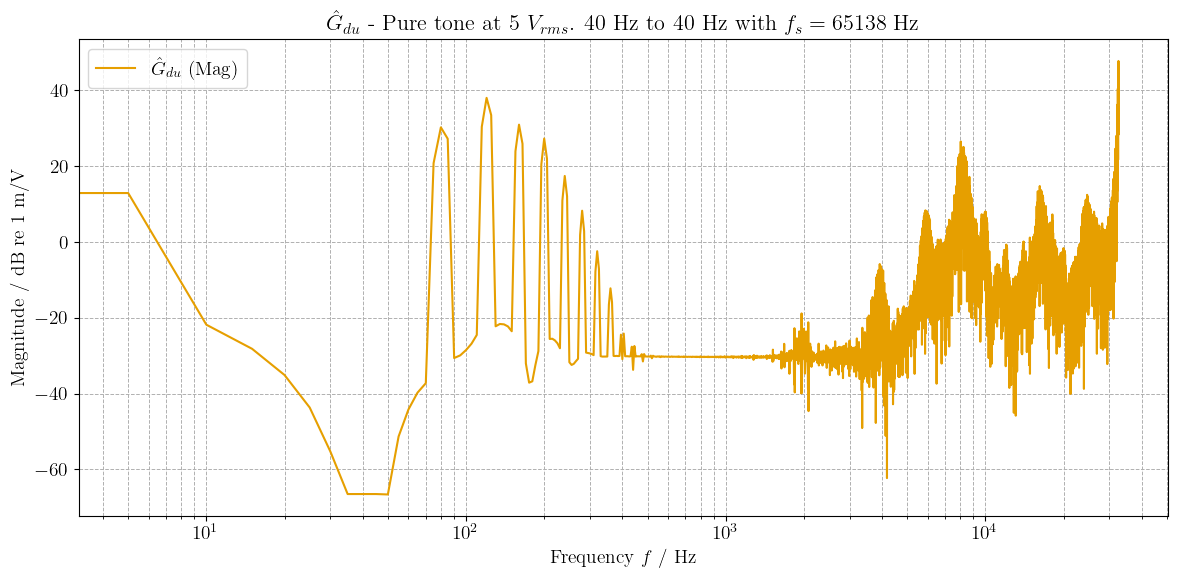

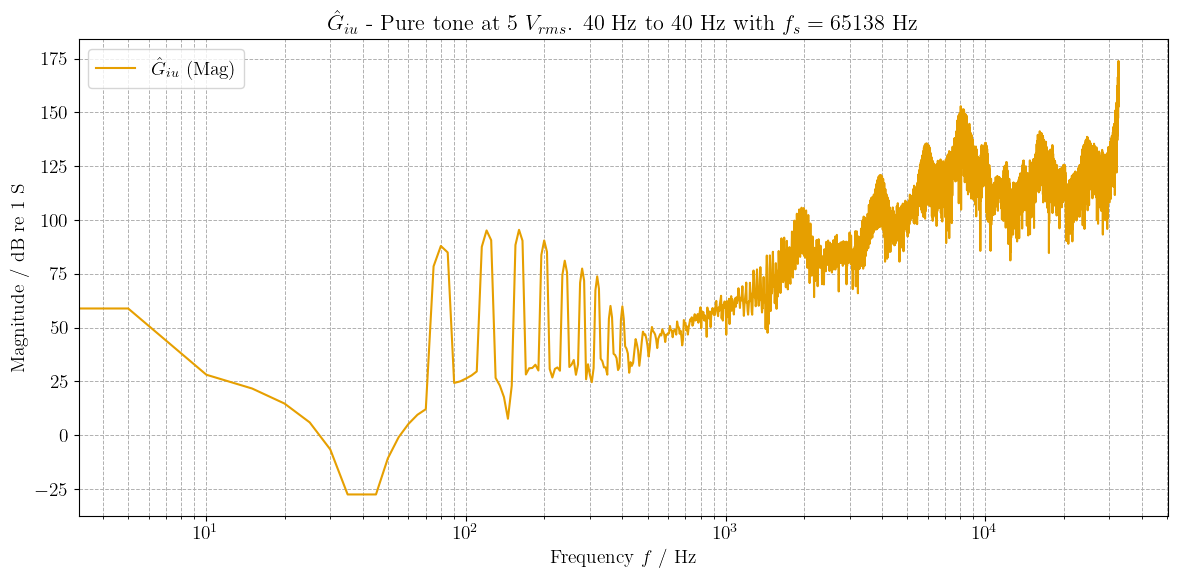

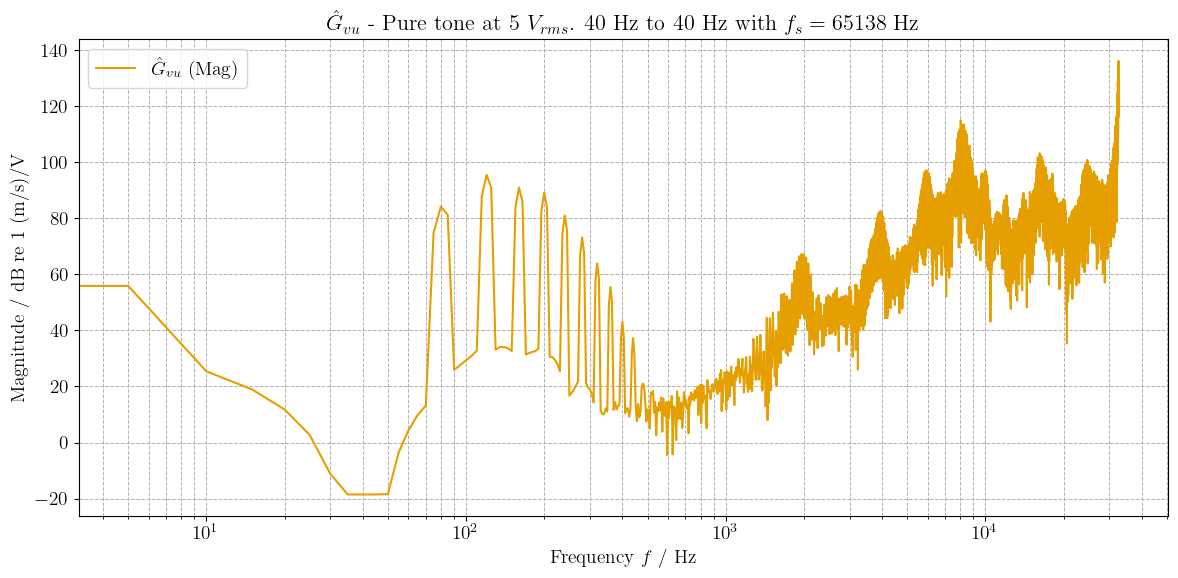

In [13]:
%load_ext autoreload
%autoreload 2
import numpy as np
import engutil
engutil = engutil.reload_self()
import util
import pandas as pd


#meta, data = util.load_simulation_results("data/part2a_presentation/01_nonlinear_full_1sec_at_65138_with_pink_noise_at_5.csv")
meta, data = util.load_simulation_results("data/part2a_presentation//01_nonlinear_full_1sec_at_65138_with_pure_tone_at_5Vrms.csv")

fs = meta["fs"]
signal_type = meta["signal_type"]
signal_level_rms = meta["signal_level_rms"]
signal_fmin = meta["signal_fmin"]
signal_fmax = meta["signal_fmax"]

print(data.keys())

t = data["time"].to_numpy()
u = data["u"].to_numpy()
i = data["i"].to_numpy()
v = data["vel"].to_numpy()
d = data["disp"].to_numpy()
X = np.array([i,d,v])

if signal_type == "pink_noise":
    signal_type_str = "Pink noise"
elif signal_type == "pure_tone":
    signal_type_str = "Pure tone"
base_title = f"{signal_type_str} at {signal_level_rms} $V_{{rms}}$. {signal_fmin} Hz to {signal_fmax} Hz with $f_s = {fs}$ Hz"

G_iu, G_du, G_vu, f = util.welchie(u, X, fs, numavgs=5)
G_iu_mag_db, _, _ = engutil.tf_to_magphase(G_iu)
G_du_mag_db, _, _ = engutil.tf_to_magphase(G_du)
G_vu_mag_db, _, _ = engutil.tf_to_magphase(G_vu)

engutil.plot_bode(f, [(G_du_mag_db, None)], legends=["$\\hat{G}_{du}$"], title=f"$\\hat{{G}}_{{du}}$ - {base_title}", ylabel_left="Magnitude / dB re 1 m/V", save_loc="figures/part-2a/nonlinear-full/G_du")
engutil.plot_bode(f, [(G_iu_mag_db, None)], legends=["$\\hat{G}_{iu}$"], title=f"$\\hat{{G}}_{{iu}}$ - {base_title}", ylabel_left="Magnitude / dB re 1 S", save_loc="figures/part-2a/nonlinear-full/G_iu")
engutil.plot_bode(f, [(G_vu_mag_db, None)], legends=["$\\hat{G}_{vu}$"], title=f"$\\hat{{G}}_{{vu}}$ - {base_title}", ylabel_left="Magnitude / dB re 1 (m/s)/V", save_loc="figures/part-2a/nonlinear-full/G_vu")



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Found 4 files. Processing...
len samples: 96000
nperseg = 19200.0
len seconds: 1.0
Processed: 01 Nonlinear Full
len samples: 96000
nperseg = 19200.0
len seconds: 1.0
Processed: 02 Nonlinear Stiffness Only
len samples: 96000
nperseg = 19200.0
len seconds: 1.0
Processed: 03 Nonlinear Bl Only
len samples: 96000
nperseg = 19200.0
len seconds: 1.0
Processed: 04 Nonlinear Le Only


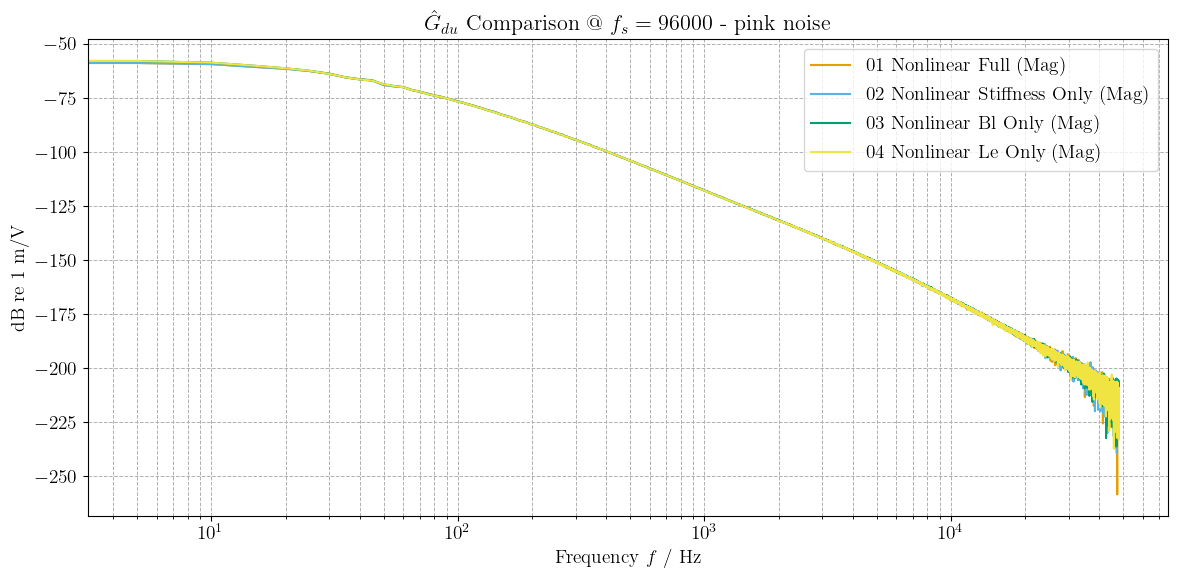

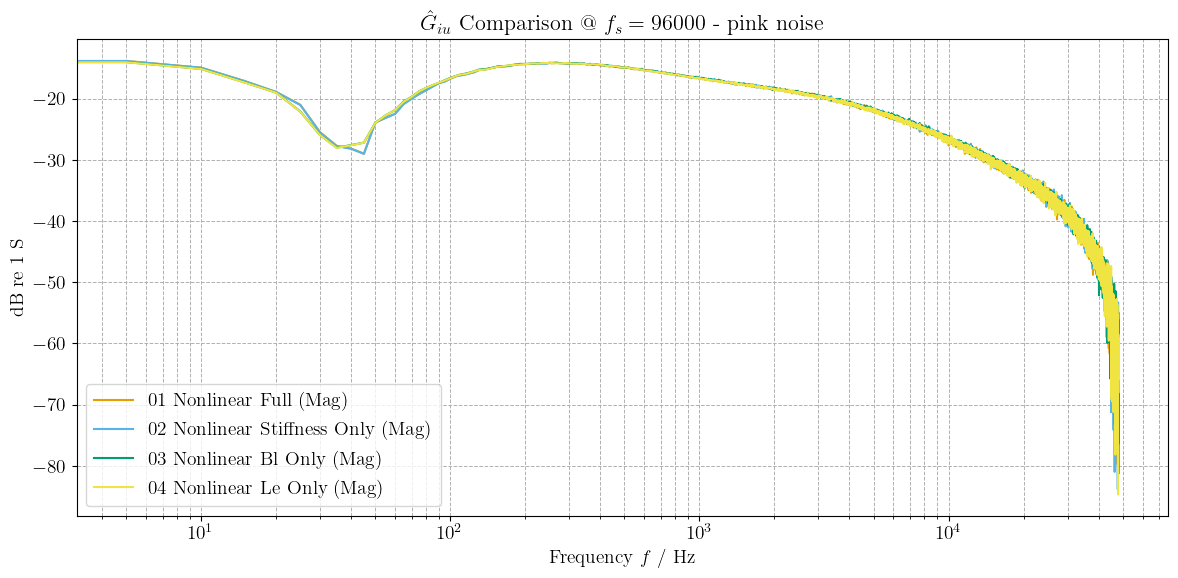

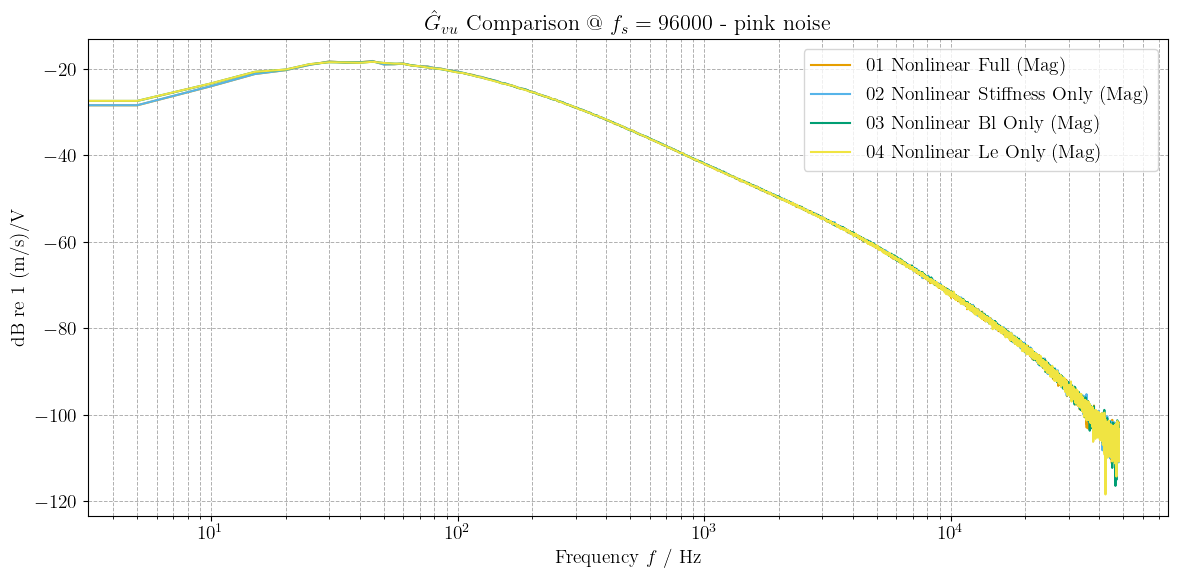

All plots generated.


In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import engutil
import util
import pandas as pd
import glob
import os


## KLIPPEL
Z = klippel.load_klippel_impedance_tf("data/lab b/measurement 1 - linear/Magnitude of electric impedance Z(f).txt")
H = klippel.load_klippel_displacement_tf("data/lab b/measurement 1 - linear/Magnitude of transfer function Hx(f)= X(f)U(f).txt")

print(Z.keys())

f_H_measured = H["measured"]["frequency"].to_numpy()
Hmag_measured = H["measured"]["value"].to_numpy()
Hmag_fitted_wo_creep = H["fitted without creep"]["value"].to_numpy()
Hmag_fitted = H["measured"]["value"].to_numpy()

f_Z_measured = Z["measured"]["frequency"].to_numpy()
Zmag_measured = Z["measured"]["value"].to_numpy()
Zmag_fitted = Z["fitted"]["value"].to_numpy()


# --------------- KLIPPEL


# 1. Find all CSV files in the directory
input_dir = "data/part2a_presentation"
# Use sorted() to ensure they load in order (01, 02, 03, 04)
file_paths = sorted(glob.glob(os.path.join(input_dir, "*.csv")))

# 2. Prepare lists to store traces for plotting
# Each item in these lists will be a tuple: (magnitude_db, phase)
traces_G_iu = []
traces_G_du = []
traces_G_vu = []

legends = []

fs = 96e3
f_axis = None # Will store the frequency vector from the first file

print(f"Found {len(file_paths)} files. Processing...")

# 3. Loop through files
for file_path in file_paths:
    # --- A. Load Data ---
    data = pd.read_csv(file_path)
    
    # Generate a clean name for the legend
    # e.g., "01_nonlinear_full_1sec..." -> "01 Nonlinear Full"
    filename = os.path.basename(file_path)
    # Split by "_1sec" to remove the tail, replace underscores with spaces
    clean_name = filename.split("_1sec")[0].replace("_", " ").title() 
    legends.append(clean_name)
    
    # --- B. Extract Signals ---
    u = data["u"].to_numpy()
    i = data["i"].to_numpy()
    v = data["vel"].to_numpy()
    d = data["disp"].to_numpy()
    X = np.array([i, d, v])

    # --- C. Calculate Transfer Functions ---
    # Calculates all 3 TFs at once
    G_iu, G_du, G_vu, f = util.welchie(u, X, fs, numavgs=5)
    
    # Store frequency axis (only need to do this once)
    if f_axis is None:
        f_axis = f

    # --- D. Convert to Magnitude (dB) ---
    G_iu_mag_db, _, _ = engutil.tf_to_magphase(G_iu)
    G_du_mag_db, _, _ = engutil.tf_to_magphase(G_du)
    G_vu_mag_db, _, _ = engutil.tf_to_magphase(G_vu)

    # --- E. Store for Plotting ---
    # engutil.plot_bode expects a list of tuples: [(mag, phase), (mag, phase), ...]
    # We pass None for phase since we aren't plotting it here
    traces_G_iu.append((G_iu_mag_db, None))
    traces_G_du.append((G_du_mag_db, None))
    traces_G_vu.append((G_vu_mag_db, None))

    print(f"Processed: {clean_name}")


# 4. Plot Everything Overlaid
# We pass the list of traces and the list of legends

# Plot G_du (Displacement)
engutil.plot_bode(
    f_axis, 
    traces_G_du, 
    legends=legends, 
    title=f"$\\hat{{G}}_{{du}}$ Comparison @ $f_s = {int(fs)}$ - pink noise", 
    ylabel_left="dB re 1 m/V", 
    save_loc="figures/part-2a/comparison_G_du"
)

# Plot G_iu (Admittance)
engutil.plot_bode(
    f_axis, 
    traces_G_iu, 
    legends=legends, 
    title=f"$\\hat{{G}}_{{iu}}$ Comparison @ $f_s = {int(fs)}$  - pink noise", 
    ylabel_left="dB re 1 S", 
    save_loc="figures/part-2a/comparison_G_iu"
)

# Plot G_vu (Velocity)
engutil.plot_bode(
    f_axis, 
    traces_G_vu, 
    legends=legends, 
    title=f"$\\hat{{G}}_{{vu}}$ Comparison @ $f_s = {int(fs)}$ - pink noise", 
    ylabel_left="dB re 1 (m/s)/V", 
    save_loc="figures/part-2a/comparison_G_vu"
)

print("All plots generated.")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Found 4 simulation files. Processing...
len samples: 96000
nperseg = 19200.0
len seconds: 1.0
Processed: 01 Nonlinear Full
len samples: 96000
nperseg = 19200.0
len seconds: 1.0
Processed: 02 Nonlinear Stiffness Only
len samples: 96000
nperseg = 19200.0
len seconds: 1.0
Processed: 03 Nonlinear Bl Only
len samples: 96000
nperseg = 19200.0
len seconds: 1.0
Processed: 04 Nonlinear Le Only
Loading Klippel Data...
Generating Plots...


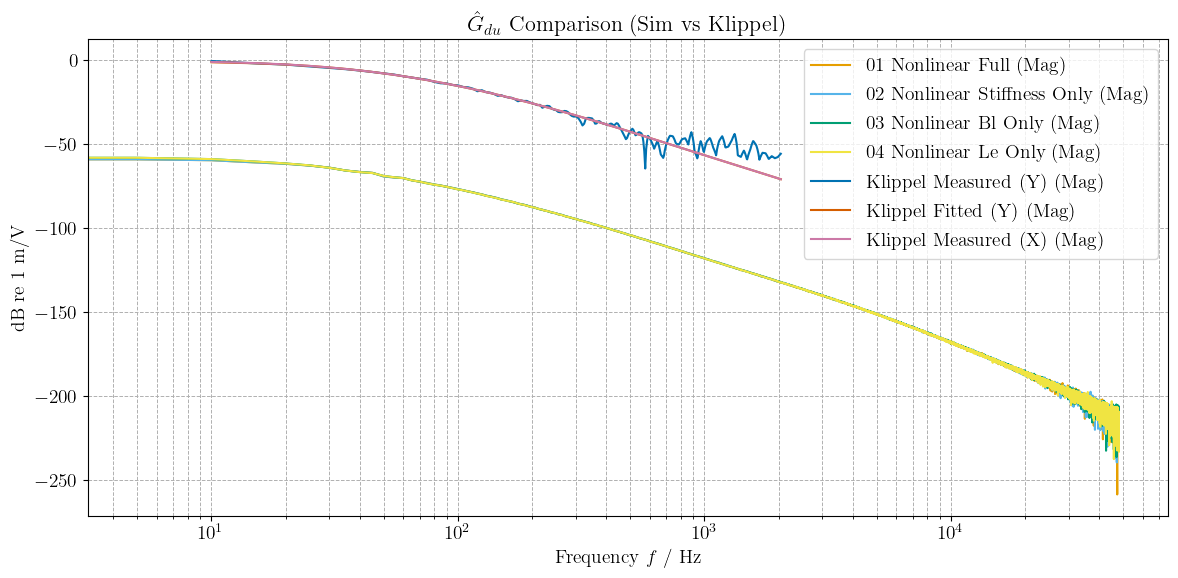

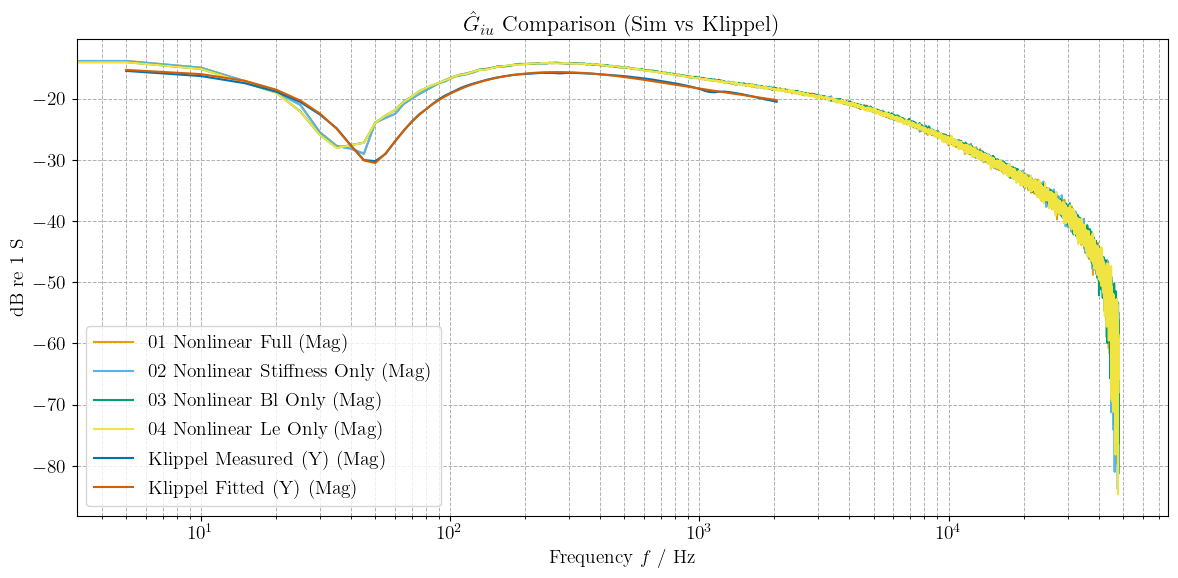

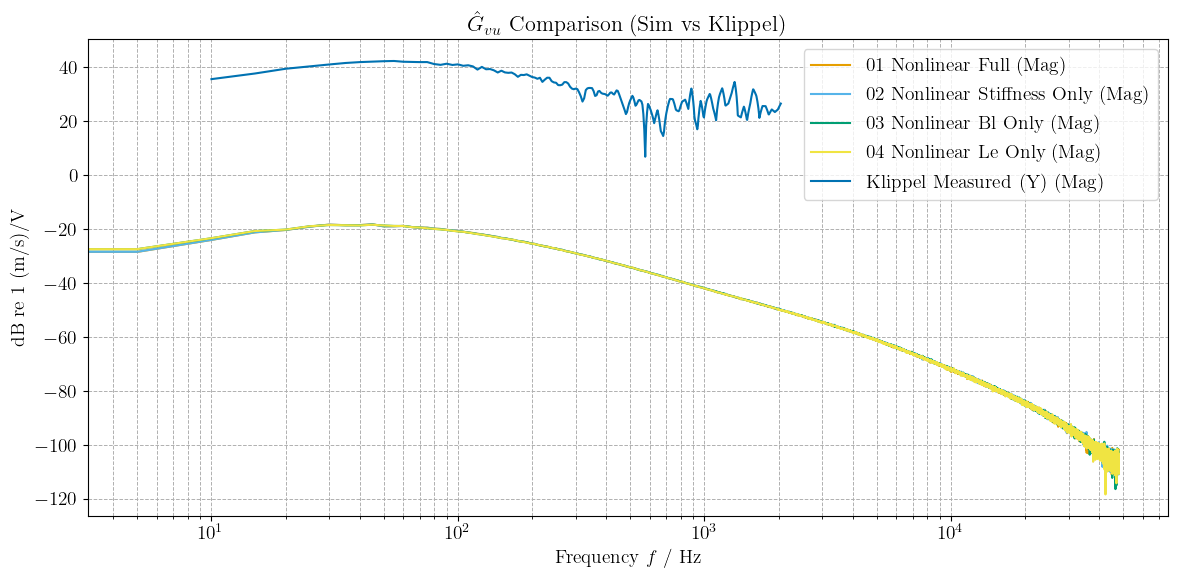

Done.


In [27]:
%load_ext autoreload
%autoreload 2
import numpy as np
import engutil
import util
import pandas as pd
import glob
import os
import klippel # Assuming you have this module

# --- 1. Setup & Simulation Loading ---
input_dir = "data/part2a_presentation"
file_paths = sorted(glob.glob(os.path.join(input_dir, "*.csv")))

traces_G_iu = []
traces_G_du = []
traces_G_vu = []
legends = []

fs = 96e3
f_axis = None 

print(f"Found {len(file_paths)} simulation files. Processing...")

for file_path in file_paths:
    # A. Load Data
    data = pd.read_csv(file_path)
    
    filename = os.path.basename(file_path)
    clean_name = filename.split("_1sec")[0].replace("_", " ").title() 
    legends.append(clean_name)
    
    # B. Extract Signals
    u = data["u"].to_numpy()
    i = data["i"].to_numpy()
    v = data["vel"].to_numpy()
    d = data["disp"].to_numpy()
    X = np.array([i, d, v])

    # C. Calculate Transfer Functions
    G_iu, G_du, G_vu, f = util.welchie(u, X, fs, numavgs=5)
    
    if f_axis is None:
        f_axis = f

    # D. Convert to Magnitude (dB)
    G_iu_mag_db, _, _ = engutil.tf_to_magphase(G_iu)
    G_du_mag_db, _, _ = engutil.tf_to_magphase(G_du)
    G_vu_mag_db, _, _ = engutil.tf_to_magphase(G_vu)

    # E. Store
    traces_G_iu.append((G_iu_mag_db, None))
    traces_G_du.append((G_du_mag_db, None))
    traces_G_vu.append((G_vu_mag_db, None))
    
    print(f"Processed: {clean_name}")

# --- 2. Load & Process Klippel Data ---
print("Loading Klippel Data...")

Z = klippel.load_klippel_impedance_tf("data/lab b/measurement 1 - linear/Magnitude of electric impedance Z(f).txt")
H = klippel.load_klippel_displacement_tf("data/lab b/measurement 1 - linear/Magnitude of transfer function Hx(f)= X(f)U(f).txt")

# Extract Klippel Arrays
f_Z_measured = Z["measured"]["frequency"].to_numpy()
Zmag_measured = Z["measured"]["value"].to_numpy()
Zmag_fitted = Z["fitted"]["value"].to_numpy()

f_H_measured = H["measured"]["frequency"].to_numpy()
Hmag_measured = H["measured"]["value"].to_numpy()
# Note: Assuming 'fitted without creep' exists in your dictionary, otherwise check keys
Hmag_fitted_wo_creep = H["fitted without creep"]["value"].to_numpy()
Hmag_fitted = H["fitted"]["value"].to_numpy() # Adjusted from your snippet (you had measured here)

# --- Helper Function for Interpolation & dB Conversion ---
def add_klippel_trace(f_target, f_src, val_src, dest_list, dest_legends, name, conversion_type="linear"):
    """
    Interpolates source data to f_target and converts to dB.
    conversion_type: 
      'linear' -> 20*log10(val)
      'impedance' -> -20*log10(val)  (Because we want Admittance 1/Z)
    """
    # 1. Interpolate onto the Simulation Frequency Axis
    # fill_value=np.nan ensures we don't draw lines outside the measured range
    val_interp = np.interp(f_target, f_src, val_src, left=np.nan, right=np.nan)
    
    # 2. Convert to dB
    if conversion_type == "impedance":
        # G_iu = 1/Z => dB = 20*log10(1/Z) = -20*log10(Z)
        val_db = -20 * np.log10(val_interp)
    else:
        # Standard Transfer Function
        val_db = 20 * np.log10(val_interp)
        
    # 3. Add to lists
    dest_list.append((val_db, None))
    dest_legends.append(name)

# --- 3. Add Klippel Data to Trace Lists ---

# Admittance Plot (G_iu)
# Note: We pass 'impedance' type to invert Z to Y
add_klippel_trace(f_axis, f_Z_measured, Zmag_measured, traces_G_iu, legends, "Klippel Measured (Y)", "impedance")
add_klippel_trace(f_axis, f_Z_measured, Zmag_fitted,   traces_G_iu, legends, "Klippel Fitted (Y)",   "impedance")

# Displacement Plot (G_du)
add_klippel_trace(f_axis, f_H_measured, Hmag_measured,        traces_G_du, legends, "Klippel Measured (X)", "linear")
add_klippel_trace(f_axis, f_H_measured, Hmag_fitted_wo_creep, traces_G_du, legends, "Klippel Fitted No Creep", "linear")
add_klippel_trace(f_axis, f_H_measured, Hmag_fitted,          traces_G_du, legends, "Klippel Fitted", "linear")

# Velocity Plot (G_vu)
# Klippel Hx is Displacement. To get Velocity, multiply by jw (or just +20dB/decade magnitude)
# Velocity = Displacement * 2*pi*f
# val_vel = Hmag * 2 * np.pi * f_src
# We calculate this specifically for the velocity plot
val_vel_measured = Hmag_measured * 2 * np.pi * f_H_measured
add_klippel_trace(f_axis, f_H_measured, val_vel_measured, traces_G_vu, legends, "Klippel Measured (V)", "linear")


# --- 4. Plotting ---

print("Generating Plots...")

# Plot G_du (Displacement)
engutil.plot_bode(
    f_axis, 
    traces_G_du, 
    legends=legends, # Note: legends list now includes simulation AND Klippel names
    title=f"$\\hat{{G}}_{{du}}$ Comparison (Sim vs Klippel)", 
    ylabel_left="dB re 1 m/V", 
    save_loc="figures/part-2a/comparison_G_du_with_klippel"
)

# Plot G_iu (Admittance)
engutil.plot_bode(
    f_axis, 
    traces_G_iu, 
    legends=legends, 
    title=f"$\\hat{{G}}_{{iu}}$ Comparison (Sim vs Klippel)", 
    ylabel_left="dB re 1 S", 
    save_loc="figures/part-2a/comparison_G_iu_with_klippel"
)

# Plot G_vu (Velocity)
engutil.plot_bode(
    f_axis, 
    traces_G_vu, 
    legends=legends, 
    title=f"$\\hat{{G}}_{{vu}}$ Comparison (Sim vs Klippel)", 
    ylabel_left="dB re 1 (m/s)/V", 
    save_loc="figures/part-2a/comparison_G_vu_with_klippel"
)

print("Done.")

In [5]:
import numpy as np
X_saved= np.array([x_history[:,0], x_history[:,1], x_history[:,2], x_history[:,3]])

np.savetxt("duration_5_sec_min_fs_5x.txt", X_saved)